# Steps

1) Download the entire MSigDB for **Human** in **JSON** format: [link](https://www.gsea-msigdb.org/gsea/downloads.jsp)
2) Search within all collections, all genesets that contains keywords related to cell cycle --> create relative df

In [107]:
import json
import os
import re
import pandas as pd

# Directory containing MSigDB JSON files
JSON_DIR = "/home/gdallagl/myworkdir/data/MSigDB/msigdb_v2025.1.Hs_json_files_to_download_locally"

# Garated genes list
GUARANTEED_GENES_PATH = "/home/gdallagl/myworkdir/data/MSigDB/julies_cycling_signatures_cancer.tsv"

# Updated keywords pattern with word boundaries to avoid false matches
KEYWORDS_PATTERN = r"(^PROLIFERA|\bPROLIFER\b|_PROLIFER_|_CYCLING_|^CELL_CYCLE_|_CELL_CYCLE_|_CC_|_G1_|_S_PHASE_|_G2_|_M_PHASE_|\bMITOSIS\b|\bCYCLIN\b|\bCDK\b|\bCHECKPOINT\b|\bGS1\b|\bGS2\b)"

# Human proteome path
HUMAN_PROTEOME_PATH = "/home/gdallagl/myworkdir/data/UniRef50/human_proteome.tsv"

# Uniref Apth
UNIREF_PATH = "/home/gdallagl/myworkdir/data/UniRef50/uniref50_human.tsv"

# Exclusion pattern
EXCLUSION_PATTERN = r"(MEIOSIS|FATTY_ACID_CYCLING_MODEL)"

# Minimum frequency threshold for filtering ambiguous genes
MIN_FREQ_AMBIGOUS = 1

## Select pathways related to cell cycle

In [72]:
def extract_matching_genesets(json_dir, pattern, exclusion_pattern=None):
    """
    Extract all gene sets from MSigDB JSON files that match the given pattern.
    
    Parameters:
    -----------
    json_dir : str
        Path to directory containing MSigDB JSON files
    pattern : str
        Regular expression pattern to match gene set names
    exclusion_pattern : str
        Regular expression pattern to exclude gene set names
        
    Returns:
    --------
    dict : Dictionary of matching gene sets with their complete information
    """
    compiled_pattern = re.compile(pattern, re.IGNORECASE)
    compiled_exclusion = re.compile(exclusion_pattern, re.IGNORECASE) if exclusion_pattern else None
    matching_genesets = {}
    excluded_count = 0
    
    # Get all JSON files in the directory
    json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]
    
    print(f"Found {len(json_files)} JSON files to process")
    
    # Process each JSON file
    for json_file in json_files:
        file_path = os.path.join(json_dir, json_file)
        
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Check each gene set in the file
            for geneset_name, geneset_info in data.items():
                if compiled_pattern.search(geneset_name):
                    # Check exclusion pattern
                    if compiled_exclusion and compiled_exclusion.search(geneset_name):
                        excluded_count += 1
                        continue
                    
                    matching_genesets[geneset_name] = geneset_info
                    
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    if excluded_count > 0:
        print(f"Excluded {excluded_count} gene sets containing 'MEIOSIS'")
    
    return matching_genesets

def save_results(genesets, output_prefix="proliferation_genesets"):
    """
    Save extracted gene sets to JSON and CSV formats.
    
    Parameters:
    -----------
    genesets : dict
        Dictionary of matching gene sets
    output_prefix : str
        Prefix for output filenames
    """
    
    # Create summary DataFrame for CSV
    summary_data = []
    for geneset_name, info in genesets.items():
        summary_data.append({
            'geneset_name': geneset_name,
            'collection': info.get('collection', ''),
            'systematicName': info.get('systematicName', ''),
            'num_genes': len(info.get('geneSymbols', [])),
            'genes': ','.join(info.get('geneSymbols', [])),
            'pmid': info.get('pmid', ''),
            'exactSource': info.get('exactSource', ''),
            'externalDetailsURL': info.get('externalDetailsURL', ''),
            'msigdbURL': info.get('msigdbURL', '')
        })
    
    df = pd.DataFrame(summary_data)
    
    return df

In [73]:
print("Extracting proliferation-related gene sets from MSigDB...")
print(f"Pattern: {KEYWORDS_PATTERN}\n")

# Extract matching gene sets
matching_genesets = extract_matching_genesets(JSON_DIR, KEYWORDS_PATTERN, EXCLUSION_PATTERN)

print(f"\nFound {len(matching_genesets)} matching gene sets")

# Create df with genest that constins keywokrs
df_summary = save_results(matching_genesets)

# Display sample of results
print("\nSample of extracted gene sets:")
display(df_summary[['geneset_name', 'collection', 'num_genes']].head(10))


list(df_summary['geneset_name'])

Extracting proliferation-related gene sets from MSigDB...
Pattern: (^PROLIFERA|\bPROLIFER\b|_PROLIFER_|_CYCLING_|^CELL_CYCLE_|_CELL_CYCLE_|_CC_|_G1_|_S_PHASE_|_G2_|_M_PHASE_|\bMITOSIS\b|\bCYCLIN\b|\bCDK\b|\bCHECKPOINT\b|\bGS1\b|\bGS2\b)

Found 34 JSON files to process
Excluded 8 gene sets containing 'MEIOSIS'

Found 144 matching gene sets

Sample of extracted gene sets:


,geneset_name,collection,num_genes
0,KEGG_MEDICUS_PATHOGEN_KSHV_VCYCLIN_TO_CELL_CYC...,C2:CP:KEGG_MEDICUS,6
1,KEGG_MEDICUS_PATHOGEN_HTLV_1_TAX_TO_P21_CELL_C...,C2:CP:KEGG_MEDICUS,8
2,KEGG_MEDICUS_REFERENCE_MDM2_P21_CELL_CYCLE_G1_...,C2:CP:KEGG_MEDICUS,11
3,KEGG_MEDICUS_VARIANT_AMPLIFIED_MDM2_TO_P21_CEL...,C2:CP:KEGG_MEDICUS,12
4,KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_P27_CELL...,C2:CP:KEGG_MEDICUS,15
5,KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_CELL_CYC...,C2:CP:KEGG_MEDICUS,11
6,KEGG_MEDICUS_REFERENCE_P300_P21_CELL_CYCLE_G1_S,C2:CP:KEGG_MEDICUS,15
7,KEGG_MEDICUS_REFERENCE_CDC25_CELL_CYCLE_G2_M,C2:CP:KEGG_MEDICUS,10
8,KEGG_MEDICUS_REFERENCE_ATR_P21_CELL_CYCLE_G2_M,C2:CP:KEGG_MEDICUS,9
9,KEGG_MEDICUS_REFERENCE_WEE1_CELL_CYCLE_G2_M,C2:CP:KEGG_MEDICUS,7


['KEGG_MEDICUS_PATHOGEN_KSHV_VCYCLIN_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_PATHOGEN_HTLV_1_TAX_TO_P21_CELL_CYCLE_G1_S_N00498',
 'KEGG_MEDICUS_REFERENCE_MDM2_P21_CELL_CYCLE_G1_S_N00536',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MDM2_TO_P21_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_P27_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_REFERENCE_P300_P21_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_REFERENCE_CDC25_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_REFERENCE_ATR_P21_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_REFERENCE_WEE1_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_PATHOGEN_HPV_E7_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_CCND1_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_CELL_CYCLE_G1_S_N00483',
 'KEGG_MEDICUS_REFERENCE_P27_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_P27_CELL_CYCLE_G1_S_N00264',
 'KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_CELL_CYCLE_G1_S_N00484',
 'KEGG_MEDICUS_PATHOGEN_HTLV_1_TAX_TO_P21_CELL_CYCLE_G1_S_N00497',
 'KEGG_MEDICUS

## Count Freq of each gene

In [74]:
def create_gene_frequency_df(df_summary):
    """
    Create a dataframe showing how many gene sets each gene appears in.
    
    Parameters:
    -----------
    df_summary : pd.DataFrame
        Summary dataframe with 'genes' column containing comma-separated gene names
        
    Returns:
    --------
    pd.DataFrame : Dataframe with columns ['gene_name', 'geneset_count']
    """
    # Dictionary to count gene occurrences
    gene_count = {}
    
    # Iterate through each gene set
    for genes_str in df_summary['genes']:
        if pd.notna(genes_str) and genes_str:  # Check if not empty
            # Split comma-separated genes
            genes_list = genes_str.split(',')
            
            # Count each gene
            for gene in genes_list:
                gene = gene.strip()  # Remove any whitespace
                if gene:  # Make sure gene name is not empty
                    gene_count[gene] = gene_count.get(gene, 0) + 1
    
    # Create dataframe from dictionary
    gene_freq_df = pd.DataFrame([
        {'gene_name': gene, 'geneset_count': count}
        for gene, count in gene_count.items()
    ])
    
    # Sort by count (descending) and then by gene name
    gene_freq_df = gene_freq_df.sort_values(
        by=['geneset_count', 'gene_name'], 
        ascending=[False, True]
    ).reset_index(drop=True)
    
    return gene_freq_df

In [75]:
gene_frequency_df = create_gene_frequency_df(df_summary)

gene_frequency_df

,gene_name,geneset_count
0,E2F1,58
1,CDK1,53
2,CCNB1,51
3,CDK2,51
4,CDKN1A,48
...,...,...
6249,ZSCAN20,1
6250,ZSCAN22,1
6251,ZSCAN9,1
6252,ZSWIM4,1


## Filter out genes with too few GS

In [76]:
gene_frequency_df["label"] = gene_frequency_df.geneset_count.apply(lambda x: 'positive' if x > MIN_FREQ_AMBIGOUS else 'ambigous')
gene_frequency_df["is_garanted"] = False

gene_frequency_df

,gene_name,geneset_count,label,is_garanted
0,E2F1,58,positive,False
1,CDK1,53,positive,False
2,CCNB1,51,positive,False
3,CDK2,51,positive,False
4,CDKN1A,48,positive,False
...,...,...,...,...
6249,ZSCAN20,1,ambigous,False
6250,ZSCAN22,1,ambigous,False
6251,ZSCAN9,1,ambigous,False
6252,ZSWIM4,1,ambigous,False


## Add Guaranteed genes

In [77]:
garanted_genes_df = pd.read_csv(GUARANTEED_GENES_PATH, sep='\t')#, names=['gene_name'])
display(garanted_genes_df.head(5))

all_values = garanted_genes_df.to_numpy().flatten().tolist()
all_values = [x for x in all_values if pd.notna(x)] # remove nan
all_values

,GBM_G1S,GBM_G2M,H3_K27M_CC,IDH_O_G1S,IDH_O_G2M,Melanoma_G1S,Melanoma_G2M
0,RRM2,CCNB1,UBE2T,MCM5,HMGB2,MCM5,HMGB2
1,PCNA,CDC20,HMGB2,PCNA,CDK1,PCNA,CDK1
2,KIAA0101,CCNB2,TYMS,TYMS,NUSAP1,TYMS,NUSAP1
3,HIST1H4C,PLK1,MAD2L1,FEN1,UBE2C,FEN1,UBE2C
4,MLF1IP,CCNA2,CDK1,MCM2,BIRC5,MCM2,BIRC5


['RRM2',
 'CCNB1',
 'UBE2T',
 'MCM5',
 'HMGB2',
 'MCM5',
 'HMGB2',
 'PCNA',
 'CDC20',
 'HMGB2',
 'PCNA',
 'CDK1',
 'PCNA',
 'CDK1',
 'KIAA0101',
 'CCNB2',
 'TYMS',
 'TYMS',
 'NUSAP1',
 'TYMS',
 'NUSAP1',
 'HIST1H4C',
 'PLK1',
 'MAD2L1',
 'FEN1',
 'UBE2C',
 'FEN1',
 'UBE2C',
 'MLF1IP',
 'CCNA2',
 'CDK1',
 'MCM2',
 'BIRC5',
 'MCM2',
 'BIRC5',
 'GMNN',
 'CKAP2',
 'UBE2C',
 'MCM4',
 'TPX2',
 'MCM4',
 'TPX2',
 'RNASEH2A',
 'KNSTRN',
 'RRM2',
 'RRM1',
 'TOP2A',
 'RRM1',
 'TOP2A',
 'MELK',
 'RACGAP1',
 'PBK',
 'UNG',
 'NDC80',
 'UNG',
 'NDC80',
 'CENPK',
 'CDCA3',
 'ZWINT',
 'GINS2',
 'CKS2',
 'GINS2',
 'CKS2',
 'TK1',
 'TROAP',
 'NUSAP1',
 'MCM6',
 'NUF2',
 'MCM6',
 'NUF2',
 'TMEM106C',
 'KIF2C',
 'PCNA',
 'CDCA7',
 'CKS1B',
 'CDCA7',
 'CKS1B',
 'CDCA5',
 'AURKA',
 'BIRC5',
 'DTL',
 'MKI67',
 'DTL',
 'MKI67',
 'CKS1B',
 'CENPF',
 'H2AFZ',
 'PRIM1',
 'TMPO',
 'PRIM1',
 'TMPO',
 'CDC45',
 'KPNA2',
 'FAM64A',
 'UHRF1',
 'CENPF',
 'UHRF1',
 'CENPF',
 'MCM3',
 'KIF20A',
 'TOP2A',
 'MLF1IP',
 'TAC

In [ ]:
# create a DataFrame for new genes
new_genes_df = pd.DataFrame({
    'gene_name': all_values,
    'geneset_count': max(gene_frequency_df.geneset_count), 
    'label': "positive",
    "is_garanted": True
})

# append to existing gene_frequency_df
gene_frequency_df = pd.concat([gene_frequency_df, new_genes_df], ignore_index=True)
gene_frequency_df.sort_values(by=['geneset_count', 'gene_name'], ascending=[False, True], inplace=True)

ambiguos_genes = set(gene_frequency_df[gene_frequency_df.label == "ambigous"].gene_name)
positive_genes = set(gene_frequency_df[gene_frequency_df.label == "positive"].gene_name)

display(gene_frequency_df)

,gene_name,geneset_count,label,is_garanted
0,ANLN,58,positive,True
1,ANLN,58,positive,True
2,ANLN,58,positive,True
3,ANLN,58,positive,True
4,ANLN,58,positive,True
...,...,...,...,...
8489,ZSCAN20,1,ambigous,False
8490,ZSCAN22,1,ambigous,False
8491,ZSCAN9,1,ambigous,False
8492,ZSWIM4,1,ambigous,False


## Dowload UniRef50

**Download Uniref50**
    - from website [link](https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29)
    - programmatically: using terminal 
        - **ATTENTION** with this call we retrive all cluster with at least 1 human protein, not just the human porteins

```bash
curl -o uniref50_human.tsv.gz "https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606))"
gunzip uniref50_human.tsv.gz
```

**Download list of all HUMAN proteins**
    - from Uniprt webite [link](https://www.uniprot.org/proteomes/UP000005640)
    - programmatically: using terminal 
```bash
wget -O human_proteome.tsv.gz "https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640)"
gunzip human_proteome.tsv.gz
```

In [ ]:
proteome_df = pd.read_csv(HUMAN_PROTEOME_PATH, sep='\t')
display(proteome_df)

all_human_proteins = set(proteome_df['Entry'].unique())
all_humans_genes = set(proteome_df['Gene Names'].unique())
len(all_human_proteins)

# little check
len(all_human_proteins.intersection(positive_genes))
len(all_humans_genes.intersection(positive_genes))

# add protein anme
gene_frequency_df["mapped_protein_name"] = gene_frequency_df['gene_name'].map(
    proteome_df.drop_duplicates(subset='Gene Names').set_index('Gene Names')['Protein names'] # ATTENTION DUPLICATED !!!
)
display(gene_frequency_df[gene_frequency_df.mapped_protein_name.notna()])

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Sequence
0,A0A087WZT3,unreviewed,A0A087WZT3_HUMAN,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6,Homo sapiens (Human),MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS
1,A0A087X1C5,reviewed,CP2D7_HUMAN,Cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7,Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
2,A0A087X296,unreviewed,A0A087X296_HUMAN,Prostaglandin G/H synthase 1 (EC 1.14.99.1) (C...,PTGS1,Homo sapiens (Human),MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...
3,A0A0A0MQV1,unreviewed,A0A0A0MQV1_HUMAN,11-beta-hydroxysteroid dehydrogenase 1 (EC 1.1...,HSD11B1,Homo sapiens (Human),MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...
4,A0A0A0MRG2,unreviewed,A0A0A0MRG2_HUMAN,Amyloid-beta precursor protein (ABPP) (Alzheim...,APP,Homo sapiens (Human),MFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQ...
...,...,...,...,...,...,...,...
83582,X6RLT1,unreviewed,X6RLT1_HUMAN,Negative elongation factor complex member C/D,NELFCD,Homo sapiens (Human),XEGMAGAVPGAIMDEDYYGSAAEWGDEADGGQQEDDSGEGEDDAEV...
83583,X6RLU5,unreviewed,X6RLU5_HUMAN,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4,Homo sapiens (Human),XELVREVLFDAVVTAPMEAYWTALALNMSEESEHVVDMAFLGTRAG...
83584,X6RLV5,unreviewed,X6RLV5_HUMAN,DEAD-box helicase 5,DDX5,Homo sapiens (Human),MSGYSSDRDRGRDRGFGAPRFGGSRAGPLSGKKFGNPGEKLVKKKW...
83585,X6RLY7,unreviewed,X6RLY7_HUMAN,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4,Homo sapiens (Human),MKLEFLQRKFWAATRQCSTVDGPCTQSCEDSDLDCFVIDNNGFILI...


,gene_name,geneset_count,label,is_garanted,mapped_protein_name
0,ANLN,58,positive,True,Anillin
1,ANLN,58,positive,True,Anillin
2,ANLN,58,positive,True,Anillin
3,ANLN,58,positive,True,Anillin
4,ANLN,58,positive,True,Anillin
...,...,...,...,...,...
8486,ZNHIT3,1,ambigous,False,Zinc finger HIT domain-containing protein 3
8488,ZSCAN2,1,ambigous,False,Zinc finger and SCAN domain-containing protein...
8491,ZSCAN9,1,ambigous,False,Zinc finger and SCAN domain containing 9
8492,ZSWIM4,1,ambigous,False,Zinc finger SWIM domain-containing protein 4


,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members
0,UniRef50_A0A023IPH8,Cluster: Integrin a4 subunit (Fragment),Homo sapiens (Human); Aotus azarae (Azara's ni...,66.0,0.5,10.0,A0A023IPH8; I3W9R5; I3W9G8; G4Y4J2; I3W9I5; I3...
1,",",NaN,NaN,NaN,NaN,NaN,NaN
2,UniRef50_A0A023IQH3,Cluster: Integrin b7 subunit (Fragment),Homo sapiens (Human),74.0,0.5,1.0,A0A023IQH3
3,",",NaN,NaN,NaN,NaN,NaN,NaN
4,UniRef50_A0A023JC58,Cluster: Proline-serine-threonine phosphatase ...,Homo sapiens (Human); Lontra canadensis,24.0,0.5,2.0,A0A023JC58; UPI0013F31E1D


(101953, 7)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members
0,UniRef50_A0A023IPH8,Cluster: Integrin a4 subunit (Fragment),Homo sapiens (Human); Aotus azarae (Azara's ni...,66.0,0.5,10.0,A0A023IPH8; I3W9R5; I3W9G8; G4Y4J2; I3W9I5; I3...
2,UniRef50_A0A023IQH3,Cluster: Integrin b7 subunit (Fragment),Homo sapiens (Human),74.0,0.5,1.0,A0A023IQH3
4,UniRef50_A0A023JC58,Cluster: Proline-serine-threonine phosphatase ...,Homo sapiens (Human); Lontra canadensis,24.0,0.5,2.0,A0A023JC58; UPI0013F31E1D
6,UniRef50_A0A023PPR2,Cluster: RUNX1/RUNX1T1 fusion protein,Homo sapiens (Human),47.0,0.5,1.0,A0A023PPR2
8,UniRef50_A0A023T4H3,Cluster: PVT1/EYA1 fusion protein isoform 3 (F...,Homo sapiens (Human),90.0,0.5,2.0,A0A023T4H3; A0A023T2M3


(50977, 7)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size
0,UniRef50_A0A023IPH8,Cluster: Integrin a4 subunit (Fragment),Homo sapiens (Human); Aotus azarae (Azara's ni...,66.0,0.5,10.0,A0A023IPH8; I3W9R5; I3W9G8; G4Y4J2; I3W9I5; I3...,,0
2,UniRef50_A0A023IQH3,Cluster: Integrin b7 subunit (Fragment),Homo sapiens (Human),74.0,0.5,1.0,A0A023IQH3,,0
4,UniRef50_A0A023JC58,Cluster: Proline-serine-threonine phosphatase ...,Homo sapiens (Human); Lontra canadensis,24.0,0.5,2.0,A0A023JC58; UPI0013F31E1D,,0
6,UniRef50_A0A023PPR2,Cluster: RUNX1/RUNX1T1 fusion protein,Homo sapiens (Human),47.0,0.5,1.0,A0A023PPR2,,0
8,UniRef50_A0A023T4H3,Cluster: PVT1/EYA1 fusion protein isoform 3 (F...,Homo sapiens (Human),90.0,0.5,2.0,A0A023T4H3; A0A023T2M3,,0


(50977, 9)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size
14,UniRef50_A0A024R1R8,Cluster: Translation machinery-associated prot...,Homo sapiens (Human); Pan troglodytes (Chimpan...,64.0,0.5,72.0,A0A024R1R8; A0A2J8LNF8; A0A8C5JYP8; A0A430Q7X9...,A0A024R1R8,1
94,UniRef50_A0A075B6H3,Cluster: Transmembrane and coiled-coil domains 4,Homo sapiens (Human); Nomascus leucogenys (Nor...,580.0,0.5,21.0,A0A075B6H3; A0A2I3GHP4; A0A673UJ66; A0A7K7WMN6...,A0A075B6H3,1
96,UniRef50_A0A075B6H8,Cluster: Probable non-functional immunoglobuli...,Homo sapiens (Human); Pongo abelii (Sumatran o...,117.0,0.5,16.0,A0A075B6H8; A0A2J8R5R9; A2NXD2; A0A8I5UJN9; A0...,A0A075B6H8,1
98,UniRef50_A0A075B6H9,Cluster: Immunoglobulin lambda variable 4-69,Homo sapiens (Human); Macaca fascicularis (Cra...,119.0,0.5,23.0,A0A075B6H9; Q5NV92; G7PHC0; G7N3D0; A0AA48P8V4...,A0A075B6H9,1
100,UniRef50_A0A075B6I0,Cluster: Immunoglobulin lambda variable 8-61,Homo sapiens (Human); Macaca mulatta (Rhesus m...,122.0,0.5,19.0,A0A075B6I0; G7N3C5; G8F4Z1; A0AA48PAE9; A0A2K5...,A0A075B6I0,1


(32803, 9)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size,Human Positive Cluster members,Human Positive Size
14,UniRef50_A0A024R1R8,Cluster: Translation machinery-associated prot...,Homo sapiens (Human); Pan troglodytes (Chimpan...,64.0,0.5,72.0,A0A024R1R8; A0A2J8LNF8; A0A8C5JYP8; A0A430Q7X9...,A0A024R1R8,1,,0
94,UniRef50_A0A075B6H3,Cluster: Transmembrane and coiled-coil domains 4,Homo sapiens (Human); Nomascus leucogenys (Nor...,580.0,0.5,21.0,A0A075B6H3; A0A2I3GHP4; A0A673UJ66; A0A7K7WMN6...,A0A075B6H3,1,,0
96,UniRef50_A0A075B6H8,Cluster: Probable non-functional immunoglobuli...,Homo sapiens (Human); Pongo abelii (Sumatran o...,117.0,0.5,16.0,A0A075B6H8; A0A2J8R5R9; A2NXD2; A0A8I5UJN9; A0...,A0A075B6H8,1,,0
98,UniRef50_A0A075B6H9,Cluster: Immunoglobulin lambda variable 4-69,Homo sapiens (Human); Macaca fascicularis (Cra...,119.0,0.5,23.0,A0A075B6H9; Q5NV92; G7PHC0; G7N3D0; A0AA48P8V4...,A0A075B6H9,1,,0
100,UniRef50_A0A075B6I0,Cluster: Immunoglobulin lambda variable 8-61,Homo sapiens (Human); Macaca mulatta (Rhesus m...,122.0,0.5,19.0,A0A075B6I0; G7N3C5; G8F4Z1; A0AA48PAE9; A0A2K5...,A0A075B6I0,1,,0


(32803, 11)

,Cluster ID,Cluster Name,Organisms,Length,Identity,Size,Cluster members,Human Cluster members,Human Size,Human Positive Cluster members,Human Positive Size


(0, 11)

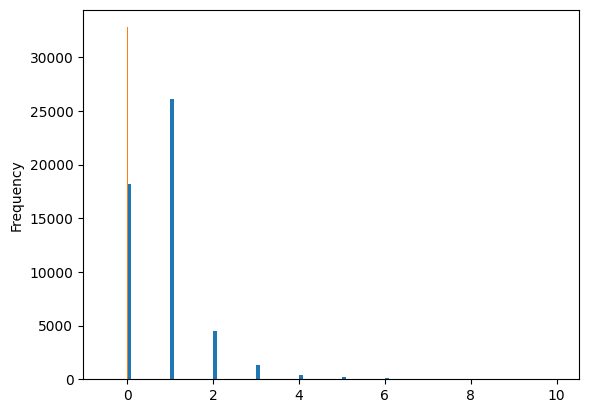

In [136]:
# Load
uniref_df = pd.read_csv(UNIREF_PATH, sep='\t') 
display(uniref_df.head(5))
display(uniref_df.shape)

# Take only even rows (problem with file formatting)
uniref_df = uniref_df.iloc[::2, :] 
display(uniref_df.head(5))
display(uniref_df.shape)

# Remove proteins that are not human
# It might contain additional info like "P12345 (Protein name)" not just IDs
uniref_df["Human Cluster members"] = uniref_df["Cluster members"].apply(
    lambda x: ";".join([
        member.strip() for member in str(x).split(";") 
        if member.strip().split()[0] in all_human_proteins  # Get first token (the ID)
    ]) if pd.notna(x) else ""
)
uniref_df["Human Size"] = uniref_df["Human Cluster members"].apply(
    lambda x: len(x.split(";")) if x else 0
)
display(uniref_df.head(5))
display(uniref_df.shape)

uniref_df["Human Size"].plot(kind="hist", bins=100)

# filter out clusters with 0 freq
uniref_df = uniref_df[uniref_df["Human Size"] > 0]
display(uniref_df.head(5))
display(uniref_df.shape)

# get only clusters with at òeat one paostve protein
uniref_df["Human Positive Cluster members"] = uniref_df["Human Cluster members"].apply(
    lambda x: ";".join([
        member.strip() for member in str(x).split(";") 
        if member.strip().split()[0] in positive_genes  # Get first token (the ID)
    ]) if pd.notna(x) else ""
)
uniref_df["Human Positive Size"] = uniref_df["Human Positive Cluster members"].apply(
    lambda x: len(x.split(";")) if x else 0
)
display(uniref_df.head(5))
display(uniref_df.shape)

uniref_df["Human Positive Size"].plot(kind="hist", bins=100)

# filter out clusters with 0 freq
uniref_df = uniref_df[uniref_df["Human Positive Size"] > 0]
display(uniref_df.head(5))
display(uniref_df.shape)


## Prob being sampled

Necessary for later